In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister, IBMQ, Aer, __qiskit_version__
from qiskit.circuit.library import QFT, GraphState, GroverOperator
from qiskit.qasm import pi

import numpy as np
import matplotlib.pyplot as plt

from src.utils import *
from src.benchmarks import grover, qaoa, ghz, qft, qft_entangled, shor, w_state, qpe_inexact, qpe_exact, graph_state, vqe, deutsch_jozsa, hhl, canonical_ae

In [2]:
provider = IBMQ.load_account()
backend = provider.backend.ibmq_santiago
c_map = backend.configuration().coupling_map

c_map_rigetti = [[5,4],[4,3],[3,2],[2,],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],]

#from qiskit.test.mock import FakeMontreal
#fake_backend = FakeMontreal()
#c_map = fake_backend.configuration().coupling_map

max_n_arch = max(max(c_map))

In [3]:
basis_gates = backend.configuration().basis_gates
basis_gates

['id', 'rz', 'sx', 'x', 'cx', 'reset']

In [4]:
benchmarks = [graph_state, grover, qaoa, ghz, qft, w_state, qpe_inexact, qpe_exact, vqe, deutsch_jozsa, hhl, shor, canonical_ae]

In [ ]:
n_min = 3
n_max = 6
opt_level = 2
num_qubits_test = 5
save_hist = True
simulator = Aer.get_backend('qasm_simulator')

In [ ]:
characteristics = []

for benchmark in benchmarks:
    print(benchmark)
    if benchmark == shor or benchmark == (hhl):
        continue
    for n in range(n_min, n_max):  
        qc = benchmark.create_circuit(n)
        serialize_qc(qc, n)  
        
        filename = qc.name + str(n) 
        save_circ(qc, filename)
        
        compiled_without_architecure = get_compiled_circuit(qc = qc, opt_level=opt_level, basis_gates=basis_gates)
        save_as_qasm(compiled_without_architecure, n, basis_gates)       
        
        filename = qc.name + "_transpiled_" + str(n) 
        depth = compiled_without_architecure.depth()
        
        characteristics.append([filename, n, depth]) 
        save_circ(compiled_without_architecure, filename)   
        
        if save_hist:
            sim_and_print_hist(compiled_without_architecure, simulator, filename)
        
        if (len(compiled_without_architecure.qubits) < max_n_arch):
            compiled_with_architecture = get_compiled_circuit(qc = qc, opt_level=opt_level, 
                                                              basis_gates=basis_gates, c_map=c_map)
            save_as_qasm(compiled_with_architecture, n, basis_gates, True, c_map, backend.name() if backend.name() else "")
            
            filename = qc.name + "_transpiled_mapped_" + str(n)
            depth = compiled_with_architecture.depth()
            characteristics.append([filename, n, depth])
            save_circ(compiled_with_architecture, filename)

            if save_hist:
                sim_and_print_hist(compiled_with_architecture, simulator, filename)

#create_shor_benchmarks()
#create_hhl_benchmarks()

In [ ]:
characteristics = np.array(characteristics)
plt.scatter(x=characteristics[:,1].astype(int), y=characteristics[:,2].astype(int))
plt.yscale('log')
plt.title('Depth and Width of generated Benchmarks')
plt.xlabel('# of Qubits')
plt.ylabel('Circuit Depth');

In [ ]:
def create_shor_benchmarks():
    small = [15,4] #18 qubits
    medium = [821, 4] #42 qubits
    large = [11777, 4] #58 qubits
    xlarge = [201209, 4] # 74 qubits
    benchmark_list = [small]#, medium, large, xlarge]
    for n, a in benchmark_list:         
        qc = shor.create_circuit(n,a)
        num_qubits = len(qc.qubits)
        
        serialize_qc(qc, num_qubits) 
        
        filename = qc.name + str(n) 
        save_circ(qc, filename)
        
        compiled_without_architecure = get_compiled_circuit(qc = qc, opt_level=opt_level, basis_gates=basis_gates)
        num_qubits = len(compiled_without_architecure.qubits)
        save_as_qasm(compiled_without_architecure, num_qubits, basis_gates) 
        
        filename = qc.name + "_transpiled_" + str(num_qubits)
        depth = compiled_without_architecure.depth()        
        characteristics.append([filename, num_qubits, depth])
        save_circ(compiled_without_architecure, filename)   
        
        if save_hist:
            sim_and_print_hist(compiled_without_architecure, simulator, filename)
        
        if (num_qubits < max_n_arch):
            compiled_with_architecture = get_compiled_circuit(qc = qc, opt_level=opt_level,
                                                              basis_gates=basis_gates, c_map=c_map)
            save_as_qasm(compiled_with_architecture, num_qubits, basis_gates, True, c_map, 
                         backend.name() if backend.name() else "")
            
            filename = qc.name + "_transpiled_mapped_" + str(num_qubits)
            depth = compiled_with_architecture.depth()
            characteristics.append([filename, num_qubits, depth])
            save_circ(compiled_with_architecture, filename)
            
            if save_hist:
                sim_and_print_hist(compiled_with_architecture, simulator, filename)

In [ ]:
def create_hhl_benchmarks():
    # n is not the number of qubits in this case
    for n in range(1,4):         
        qc = hhl.create_circuit(n)
        
        num_qubits = len(qc.qubits)
        
        serialize_qc(qc, num_qubits) 
        compiled_without_architecure = get_compiled_circuit(qc = qc, opt_level=opt_level, basis_gates=basis_gates)
        num_qubits = len(compiled_without_architecure.qubits)
        save_as_qasm(compiled_without_architecure, num_qubits)        
        
        filename = qc.name + "_transpiled_" + str(num_qubits)
        depth = compiled_without_architecure.depth()        
        characteristics.append([filename, num_qubits, depth])
        
        if print_hist:
            sim_and_print_hist(compiled_without_architecure, simulator, filename)
        
        if (num_qubits < max_n_arch):
            compiled_with_architecture = get_compiled_circuit(qc = qc, opt_level=opt_level, 
                                                              basis_gates=basis_gates, c_map=c_map)
            save_as_qasm(compiled_with_architecture, num_qubits, True)
            
            filename = qc.name + "_transpiled_mapped_" + str(num_qubits)
            depth = compiled_with_architecture.depth()
            characteristics.append([filename, num_qubits, depth])
            
            if print_hist:
                sim_and_print_hist(compiled_with_architecture, simulator, filename)

Grover Test

In [ ]:
a = grover.create_circuit(num_qubits_test)
b = get_compiled_circuit(a, opt_level=2, basis_gates=basis_gates)
save_as_qasm(b, num_qubits_test, basis_gates)
c = get_compiled_circuit(b, opt_level=2, basis_gates=basis_gates, c_map=c_map)
save_as_qasm(c, num_qubits_test, basis_gates, True, c_map, backend.name() if backend.name() else "")

QAOA Test

In [ ]:
a = qaoa.create_circuit(num_qubits_test)
b = get_compiled_circuit(a, opt_level=2, basis_gates=basis_gates)
save_as_qasm(b, num_qubits_test, basis_gates)
c = get_compiled_circuit(b, opt_level=2, basis_gates=basis_gates, c_map=c_map)
save_as_qasm(c, num_qubits_test, basis_gates, True, c_map, backend.name() if backend.name() else "")

GHZ Test

In [ ]:
a = ghz.create_circuit(num_qubits_test)
b = get_compiled_circuit(a, opt_level=2, basis_gates=basis_gates)
save_as_qasm(b, num_qubits_test, basis_gates)
c = get_compiled_circuit(b, opt_level=2, basis_gates=basis_gates, c_map=c_map)
save_as_qasm(c, num_qubits_test, basis_gates, True, c_map, backend.name() if backend.name() else "")

QFT Test

In [ ]:
a = qft.create_circuit(num_qubits_test)
b = get_compiled_circuit(a, opt_level=2, basis_gates=basis_gates)
save_as_qasm(b, num_qubits_test, basis_gates)
c = get_compiled_circuit(b, opt_level=2, basis_gates=basis_gates, c_map=c_map)
save_as_qasm(c, num_qubits_test, basis_gates, True, c_map, backend.name() if backend.name() else "")

QFT Entangled Test

In [ ]:
a = qft_entangled.create_circuit(num_qubits_test)
b = get_compiled_circuit(a, opt_level=2, basis_gates=basis_gates)
save_as_qasm(b, num_qubits_test, basis_gates)
c = get_compiled_circuit(b, opt_level=2, basis_gates=basis_gates, c_map=c_map)
save_as_qasm(c, num_qubits_test, basis_gates, True, c_map, backend.name() if backend.name() else "")

W-State Test

In [ ]:
a = w_state.create_circuit(num_qubits_test)
b = get_compiled_circuit(a, opt_level=2, basis_gates=basis_gates)
save_as_qasm(b, num_qubits_test, basis_gates)
c = get_compiled_circuit(b, opt_level=2, basis_gates=basis_gates, c_map=c_map)
save_as_qasm(c, num_qubits_test, basis_gates, True, c_map, backend.name() if backend.name() else "")

In [ ]:
a.draw(output="mpl", filename="test.png")

QPE Exact and QPE Inexact Test

In [ ]:
a = qpe_exact.create_circuit(num_qubits_test)
b = get_compiled_circuit(a, opt_level=2, basis_gates=basis_gates)
save_as_qasm(b, num_qubits_test, basis_gates)
c = get_compiled_circuit(b, opt_level=2, basis_gates=basis_gates, c_map=c_map)
save_as_qasm(c, num_qubits_test, basis_gates, True, c_map, backend.name() if backend.name() else "")

a = qpe_inexact.create_circuit(num_qubits_test)
b = get_compiled_circuit(a, opt_level=2, basis_gates=basis_gates)
save_as_qasm(b, num_qubits_test, basis_gates)
c = get_compiled_circuit(b, opt_level=2, basis_gates=basis_gates, c_map=c_map)
save_as_qasm(c, num_qubits_test, basis_gates, True, c_map, backend.name() if backend.name() else "")

Graph State Test

In [ ]:
a = graph_state.create_circuit(num_qubits_test)
b = get_compiled_circuit(a, opt_level=2, basis_gates=basis_gates)
save_as_qasm(b, num_qubits_test, basis_gates)
c = get_compiled_circuit(b, opt_level=2, basis_gates=basis_gates, c_map=c_map)
save_as_qasm(c, num_qubits_test, basis_gates, True, c_map, backend.name() if backend.name() else "")


Shor Test

In [ ]:
a = shor.create_circuit(15)
b = get_compiled_circuit(a, opt_level=2, basis_gates=basis_gates)
save_as_qasm(b, None, basis_gates)
#c = get_compiled_circuit(b, opt_level=2, c_map=c_map)
#save_as_qasm(c, None, True)

AE Test

In [ ]:
a = ae.create_circuit(num_qubits_test)
b = get_compiled_circuit(a, opt_level=2, basis_gates=basis_gates)
save_as_qasm(b, num_qubits_test, basis_gates)
c = get_compiled_circuit(b, opt_level=2, basis_gates=basis_gates, c_map=c_map)
save_as_qasm(c, num_qubits_test, basis_gates, True, c_map, backend.name() if backend.name() else "")

DJ Test

In [ ]:
num_qubits_test = 5
a = deutsch_jozsa.create_circuit(num_qubits_test)
b = get_compiled_circuit(a, opt_level=2, basis_gates=basis_gates)
save_as_qasm(b, num_qubits_test, basis_gates)
c = get_compiled_circuit(b, opt_level=2, basis_gates=basis_gates, c_map=c_map)
save_as_qasm(c, num_qubits_test, basis_gates, True, c_map, backend.name() if backend.name() else "")

HHL Test

In [ ]:
import src.benchmarks.hhl
num_qubits_test = 3
a = hhl.create_circuit(num_qubits_test)
b = get_compiled_circuit(a, opt_level=2, basis_gates=basis_gates)
save_as_qasm(b, num_qubits_test, basis_gates)
c = get_compiled_circuit(b, opt_level=2, basis_gates=basis_gates, c_map=c_map)
save_as_qasm(c, num_qubits_test, basis_gates, True, c_map, backend.name() if backend.name() else "")

Example Generation for a figure in the paper

In [ ]:
#from qiskit.circuit.library import RealAmplitudes
#from qiskit.visualization import plot_histogram, plot_gate_map, plot_circuit_layout
#plot_gate_map(backend).savefig("layout_santiago.png")
#ansatz = RealAmplitudes(3, reps=1)
#qc = ansatz.decompose()
#qc.draw(output="mpl", filename="paper_example_1_1")
#b = get_compiled_circuit(qc, opt_level=0, basis_gates=basis_gates)
#b.draw(output="mpl", filename="paper_example_1_2")
#c = get_compiled_circuit(b, opt_level=0, basis_gates=basis_gates, c_map=c_map)
#c.draw(output="mpl", filename="paper_example_1_3")

Qiskit Finance Test

In [ ]:

from src.benchmarks.qiskit_application_finance import portfolio_optimization_qaoa, portfolio_optimization_vqe, pricing_eur_call_opt, pricing_eur_put_opt
num_qubits_test = 5
a = pricing_eur_put_opt.create_circuit(num_qubits_test)
b = get_compiled_circuit(a, opt_level=2, basis_gates=basis_gates)
save_as_qasm(b, num_qubits_test, basis_gates)
c = get_compiled_circuit(b, opt_level=2, basis_gates=basis_gates, c_map=c_map)
save_as_qasm(c, num_qubits_test, basis_gates, True, c_map, backend.name() if backend.name() else "")

Qiskit Optimization Test

In [ ]:

from src.benchmarks.qiskit_application_optimization import vehicle_routing
num_qubits_test = 5
a = vehicle_routing.create_circuit(3,3)
#b = get_compiled_circuit(a, opt_level=2)
#save_as_qasm(b, num_qubits_test)
#c = get_compiled_circuit(b, opt_level=2, c_map=c_map)
#save_as_qasm(c, num_qubits_test, True)

Qiskit Machine Learning Test

In [ ]:
import numpy as np
seed = 71
np.random.seed = seed

import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import QuantumRegister, QuantumCircuit, BasicAer
from qiskit.circuit.library import TwoLocal, UniformDistribution

from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import NumPyDiscriminator, QGAN

algorithm_globals.random_seed = seed

# Number training data samples
N = 1000

# Load data samples from log-normal distribution with mean=1 and standard deviation=1
mu = 1
sigma = 1
real_data = np.random.lognormal(mean=mu, sigma=sigma, size=N)

# Set the data resolution
# Set upper and lower data values as list of k min/max data values [[min_0,max_0],...,[min_k-1,max_k-1]]
bounds = np.array([0., 3.])
# Set number of qubits per data dimension as list of k qubit values[#q_0,...,#q_k-1]
num_qubits = [2]
k = len(num_qubits)

In [ ]:
# Set number of training epochs
# Note: The algorithm's runtime can be shortened by reducing the number of training epochs.
num_epochs = 10
# Batch size
batch_size = 100

 # Initialize qGAN
qgan = QGAN(real_data, bounds, num_qubits, batch_size, num_epochs, snapshot_dir=None)
qgan.seed = 1
# Set quantum instance to run the quantum generator
quantum_instance = QuantumInstance(backend=BasicAer.get_backend('statevector_simulator'),
                                   seed_transpiler=seed, seed_simulator=seed)

# Set entangler map
entangler_map = [[0, 1]]


# Set an initial state for the generator circuit
init_dist = UniformDistribution(sum(num_qubits))

# Set the ansatz circuit
ansatz = TwoLocal(int(np.sum(num_qubits)), 'ry', 'cz', entanglement=entangler_map, reps=1)

# Set generator's initial parameters - in order to reduce the training time and hence the
# total running time for this notebook
init_params = [3., 1., 0.6, 1.6]

# You can increase the number of training epochs and use random initial parameters.
# init_params = np.random.rand(ansatz.num_parameters_settable) * 2 * np.pi

# Set generator circuit by adding the initial distribution infront of the ansatz
g_circuit = ansatz.compose(init_dist, front=True)

# Set quantum generator
qgan.set_generator(generator_circuit=g_circuit, generator_init_params=init_params)
# The parameters have an order issue that following is a temp. workaround
qgan._generator._free_parameters = sorted(g_circuit.parameters, key=lambda p: p.name)
# Set classical discriminator neural network
discriminator = NumPyDiscriminator(len(num_qubits))
qgan.set_discriminator(discriminator)

In [ ]:
# Run qGAN
result = qgan.run(quantum_instance)

In [ ]:
print('Training results:')
for key, value in result.items():
    print(f'  {key} : {value}')

In [ ]:
# Plot progress w.r.t the generator's and the discriminator's loss function
t_steps = np.arange(num_epochs)
plt.figure(figsize=(6,5))
plt.title("Progress in the loss function")
plt.plot(t_steps, qgan.g_loss, label='Generator loss function', color='mediumvioletred', linewidth=2)
plt.plot(t_steps, qgan.d_loss, label='Discriminator loss function', color='rebeccapurple', linewidth=2)
plt.grid()
plt.legend(loc='best')
plt.xlabel('time steps')
plt.ylabel('loss')
plt.show()

In [ ]:
# Plot progress w.r.t relative entropy
plt.figure(figsize=(6,5))
plt.title('Relative Entropy')
plt.plot(np.linspace(0, num_epochs, len(qgan.rel_entr)), qgan.rel_entr, color='mediumblue', lw=4, ls=':')
plt.grid()
plt.xlabel('time steps')
plt.ylabel('relative entropy')
plt.show()

In [ ]:
#Plot the CDF of the resulting distribution against the target distribution, i.e. log-normal
log_normal = np.random.lognormal(mean=1, sigma=1, size=100000)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= bounds[1]]
temp = []
for i in range(int(bounds[1] + 1)):
    temp += [np.sum(log_normal==i)]
log_normal = np.array(temp / sum(temp))

plt.figure(figsize=(6,5))
plt.title('CDF (Cumulative Distribution Function)')
samples_g, prob_g = qgan.generator.get_output(qgan.quantum_instance, shots=10000)
samples_g = np.array(samples_g)
samples_g = samples_g.flatten()
num_bins = len(prob_g)
plt.bar(samples_g,  np.cumsum(prob_g), color='royalblue', width= 0.8, label='simulation')
plt.plot( np.cumsum(log_normal),'-o', label='log-normal', color='deepskyblue', linewidth=4, markersize=12)
plt.xticks(np.arange(min(samples_g), max(samples_g)+1, 1.0))
plt.grid()
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend(loc='best')
plt.show()

Second Example

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVC
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data

seed = 12345
algorithm_globals.random_seed = seed

In [ ]:
adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=20,
    test_size=5,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False, one_hot=False, include_sample_total=True
)

plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(np.asmatrix(adhoc_total).T, interpolation='nearest',
           origin='lower', cmap='RdBu', extent=[0, 2 * np.pi, 0, 2 * np.pi])

plt.scatter(train_features[np.where(train_labels[:] == 0), 0], train_features[np.where(train_labels[:] == 0), 1],
            marker='s', facecolors='w', edgecolors='b', label="A train")
plt.scatter(train_features[np.where(train_labels[:] == 1), 0], train_features[np.where(train_labels[:] == 1), 1],
            marker='o', facecolors='w', edgecolors='r', label="B train")
plt.scatter(test_features[np.where(test_labels[:] == 0), 0], test_features[np.where(test_labels[:] == 0), 1],
            marker='s', facecolors='b', edgecolors='w', label="A test")
plt.scatter(test_features[np.where(test_labels[:] == 1), 0], test_features[np.where(test_labels[:] == 1), 1],
            marker='o', facecolors='r', edgecolors='w', label="B test")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Ad hoc dataset for classification")

plt.show()

In [ ]:
adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension,
                                 reps=2, entanglement='linear')

adhoc_backend = QuantumInstance(BasicAer.get_backend('qasm_simulator'), shots=1024,
                                seed_simulator=seed, seed_transpiler=seed)

adhoc_kernel = QuantumKernel(feature_map=adhoc_feature_map, quantum_instance=adhoc_backend)

In [ ]:
adhoc_svc = SVC(kernel=adhoc_kernel.evaluate)
adhoc_svc.fit(train_features, train_labels)
adhoc_score = adhoc_svc.score(test_features, test_labels)

print(f'Callable kernel classification test score: {adhoc_score}')

In [ ]:
adhoc_matrix_train = adhoc_kernel.evaluate(x_vec=train_features)
adhoc_matrix_test = adhoc_kernel.evaluate(x_vec=test_features,
                                          y_vec=train_features)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(adhoc_matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("Ad hoc training kernel matrix")
axs[1].imshow(np.asmatrix(adhoc_matrix_test),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("Ad hoc testing kernel matrix")
plt.show()

adhoc_svc = SVC(kernel='precomputed')
adhoc_svc.fit(adhoc_matrix_train, train_labels)
adhoc_score = adhoc_svc.score(adhoc_matrix_test, test_labels)

print(f'Precomputed kernel classification test score: {adhoc_score}')

In [ ]:
qsvc = QSVC(quantum_kernel=adhoc_kernel)
qsvc.fit(train_features, train_labels)
qsvc_score = qsvc.score(test_features, test_labels)

print(f'QSVC classification test score: {qsvc_score}')

Third Example

In [ ]:
import numpy as np

from qiskit import Aer, QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.opflow import StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.neural_networks import OpflowQNN

In [ ]:
# set method to calculcate expected values
expval = AerPauliExpectation()

# define gradient method
gradient = Gradient()

# define quantum instances (statevector and sample based)
qi_sv = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))

# we set shots to 10 as this will determine the number of samples later on.
qi_qasm = QuantumInstance(Aer.get_backend('aer_simulator'), shots=10)

In [ ]:
# define (random) input and weights
input1 = np.random.rand(qnn1.num_inputs)
weights1 = np.random.rand(qnn1.num_weights)
# QNN forward pass
qnn1.forward(input1, weights1)
# QNN batched forward pass
qnn1.forward([input1, input1], weights1)
# QNN backward pass
qnn1.backward(input1, weights1)
# QNN batched backward pass
qnn1.backward([input1, input1], weights1)
op2 = ListOp([op1, op1])
qnn2 = OpflowQNN(op2, [params1[0]], [params1[1]], expval, gradient, qi_sv)
# QNN forward pass
qnn2.forward(input1, weights1)
# QNN backward pass
qnn2.backward(input1, weights1)

In [ ]:
from qiskit_machine_learning.neural_networks import CircuitQNN
num_qubits = 5
qc = RealAmplitudes(num_qubits, entanglement='linear', reps=2)
qc.decompose().draw(output='mpl')

In [ ]:
# specify circuit QNN
qnn4 = CircuitQNN(qc, [], qc.parameters, sparse=True, quantum_instance=qi_qasm)
# define (random) input and weights
input4 = np.random.rand(qnn4.num_inputs)
weights4 = np.random.rand(qnn4.num_weights)
# QNN forward pass
qnn4.forward(input4, weights4).todense()  # returned as a sparse matrix

In [ ]:
# QNN backward pass, returns a tuple of sparse matrices
qnn4.backward(input4, weights4)

In [ ]:
qnn4.circuit.decompose().draw()

In [ ]:
def create_circuit(num_qubits: int):
    num_qubits = num_qubits
    qc = RealAmplitudes(num_qubits, entanglement='linear', reps=2)

    # specify circuit QNN
    qnn = CircuitQNN(qc, [], qc.parameters, sparse=True, quantum_instance=qi_qasm)
    # define (random) input and weights
    np.random.seed(0)

    input = np.random.rand(qnn.num_inputs)
    weights = np.random.rand(qnn.num_weights)
    # QNN forward pass

    qc = qnn.circuit
    qc.name = "qnn"

    return qc

In [ ]:
create_circuit(10).draw()

In [ ]:
n=5
from qiskit.algorithms import Grover

n = n - 1 #magic number due to the ancilla qubit
q = QuantumRegister(n, 'q')
flag = AncillaRegister(1, 'flag')

state_preparation = QuantumCircuit(q, flag)
state_preparation.h(q)
state_preparation.x(flag)

oracle = QuantumCircuit(q, flag)
oracle.mcp(pi, q, flag)

operator = GroverOperator(oracle)
iterations = Grover.optimal_num_iterations(1, n)

qc = QuantumCircuit(q, flag, name='grover')
qc.compose(state_preparation, inplace=True)

qc.compose(operator.power(iterations), inplace=True)
qc.measure_all()

AE Test

In [ ]:
from src.benchmarks import canonical_ae


In [ ]:
from qiskit import BasicAer
from qiskit.utils import QuantumInstance

backend = BasicAer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend)

In [ ]:
a = canonical_ae.create_circuit(5)
a.draw()

Bugfixing

In [6]:
a = vqe.create_circuit(3)
a.draw()

»
   q_0: »
        »
   q_1: »
        »
   q_2: »
        »
meas: 3/»
        »
«        ┌───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐»
«   q_0: ┤0                                                                                                                                                                                  ├»
«        │                                                                                                                                                                                   │»
«   q_1: ┤1 RealAmplitudes(1.32156184553288,-2.59552406599332,-2.25162535981705,3.02029581444797,0.657877914321449,0.699957863488365,-1.44977781942241,-2.94325148396468,-0.987072251976241) ├»
«        │                                                                                                                                                                                   │»
«   q_2: ┤2                                                                                                                                                                                  ├»
«        └───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘»
«meas: 3/═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════»
«                                                                                                                                                                                             »
«         ░ ┌─┐      
«   q_0: ─░─┤M├──────
«         ░ └╥┘┌─┐   
«   q_1: ─░──╫─┤M├───
«         ░  ║ └╥┘┌─┐
«   q_2: ─░──╫──╫─┤M├
«         ░  ║  ║ └╥┘
«meas: 3/════╩══╩══╩═
«            0  1  2

In [7]:
b = qaoa.create_circuit(3)
b.draw()

┌───┐┌───┐┌──────────────────────┐┌───┐┌───┐┌──────────────────────┐»
   q_0: ┤ H ├┤ X ├┤ Rz(3.12558454739860) ├┤ X ├┤ X ├┤ Rz(3.12558454739860) ├»
        ├───┤└─┬─┘└──────────────────────┘└─┬─┘└─┬─┘└──────────────────────┘»
   q_1: ┤ H ├──■────────────────────────────■────┼──────────────────────────»
        ├───┤                                    │                          »
   q_2: ┤ H ├────────────────────────────────────■──────────────────────────»
        └───┘                                                               »
meas: 3/════════════════════════════════════════════════════════════════════»
                                                                            »
«        ┌───┐┌───────────────────────┐                             »
«   q_0: ┤ X ├┤ Rx(-3.01825799681553) ├─────────────────────────────»
«        └─┬─┘└─────────┬───┬─────────┘┌──────────────────────┐┌───┐»
«   q_1: ──┼────────────┤ X ├──────────┤ Rz(3.12558454739860) ├┤ X ├»
«          │            └─┬─┘          └──────────────────────┘└─┬─┘»
«   q_2: ──■──────────────■──────────────────────────────────────■──»
«                                                                   »
«meas: 3/═══════════════════════════════════════════════════════════»
«                                                                   »
«                                 ┌───┐┌───────────────────────┐┌───┐┌───┐»
«   q_0: ─────────────────────────┤ X ├┤ Rz(-1.07736934163726) ├┤ X ├┤ X ├»
«        ┌───────────────────────┐└─┬─┘└───────────────────────┘└─┬─┘└─┬─┘»
«   q_1: ┤ Rx(-3.01825799681553) ├──■─────────────────────────────■────┼──»
«        ├───────────────────────┤                                     │  »
«   q_2: ┤ Rx(-3.01825799681553) ├─────────────────────────────────────■──»
«        └───────────────────────┘                                        »
«meas: 3/═════════════════════════════════════════════════════════════════»
«                                                                         »
«        ┌───────────────────────┐┌───┐┌───────────────────────┐»
«   q_0: ┤ Rz(-1.07736934163726) ├┤ X ├┤ Rx(-7.19131036103420) ├»
«        └───────────────────────┘└─┬─┘└─────────┬───┬─────────┘»
«   q_1: ───────────────────────────┼────────────┤ X ├──────────»
«                                   │            └─┬─┘          »
«   q_2: ───────────────────────────■──────────────■────────────»
«                                                               »
«meas: 3/═══════════════════════════════════════════════════════»
«                                                               »
«                                                                ░ ┌─┐      
«   q_0: ────────────────────────────────────────────────────────░─┤M├──────
«        ┌───────────────────────┐┌───┐┌───────────────────────┐ ░ └╥┘┌─┐   
«   q_1: ┤ Rz(-1.07736934163726) ├┤ X ├┤ Rx(-7.19131036103420) ├─░──╫─┤M├───
«        └───────────────────────┘└─┬─┘├───────────────────────┤ ░  ║ └╥┘┌─┐
«   q_2: ───────────────────────────■──┤ Rx(-7.19131036103420) ├─░──╫──╫─┤M├
«                                      └───────────────────────┘ ░  ║  ║ └╥┘
«meas: 3/═══════════════════════════════════════════════════════════╩══╩══╩═
«                                                                   0  1  2

Rigetti Coupling Map Creation

In [77]:
c_map_rigetti = []
for j in range(4):
    for i in range(0,7):
        elem = [i+j*10, i+1+j*10]
        c_map_rigetti.append(elem)
        if i == 6:
            c_map_rigetti.append([0+j*10, 7+j*10])
            
# for i in range(10,17):
#     elem = [i, i+1]
#     c_map_rigetti.append(elem)
# for i in range(20,27):
#     elem = [i, i+1]
#     c_map_rigetti.append(elem)
# for i in range(20,27):
#     elem = [i, i+1]
#     c_map_rigetti.append(elem)
# for i in range(30,37):
#     elem = [i, i+1]
#     c_map_rigetti.append(elem)    
c_map_rigetti.extend(([2,15],[1,16],[12,25],[11,26],[22,35],[21,36]))    
print(c_map_rigetti)

[[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [0, 7], [10, 11], [11, 12], [12, 13], [13, 14], [14, 15], [15, 16], [16, 17], [10, 17], [20, 21], [21, 22], [22, 23], [23, 24], [24, 25], [25, 26], [26, 27], [20, 27], [30, 31], [31, 32], [32, 33], [33, 34], [34, 35], [35, 36], [36, 37], [30, 37], [2, 15], [1, 16], [12, 25], [11, 26], [22, 35], [21, 36]]


In [ ]:
import networkx as nx
G = nx.Graph()
G.add_edges_from(c_map_rigetti)
nx.draw(G, with_labels=True)

Google Coupling Map Creation

In [105]:
c_map_google = []
for j in range(8):
    for i in range(6):
        if j%2 == 0:
            if i != 0:
                elem = [i+6*j, i+6*j + 5]
                c_map_google.append(elem)

            if i != 6:
                elem = [i+6*j, i+6*j + 6]
                c_map_google.append(elem)

        else:
            if i != 0:
                elem = [i+6*j, i+6*j + 6]
                c_map_google.append(elem)

            if i != 6:
                elem = [i+6*j, i+6*j + 7]
                c_map_google.append(elem)
print(c_map_google)

[[0, 6], [1, 6], [1, 7], [2, 7], [2, 8], [3, 8], [3, 9], [4, 9], [4, 10], [5, 10], [5, 11], [6, 13], [7, 13], [7, 14], [8, 14], [8, 15], [9, 15], [9, 16], [10, 16], [10, 17], [11, 17], [11, 18], [12, 18], [13, 18], [13, 19], [14, 19], [14, 20], [15, 20], [15, 21], [16, 21], [16, 22], [17, 22], [17, 23], [18, 25], [19, 25], [19, 26], [20, 26], [20, 27], [21, 27], [21, 28], [22, 28], [22, 29], [23, 29], [23, 30], [24, 30], [25, 30], [25, 31], [26, 31], [26, 32], [27, 32], [27, 33], [28, 33], [28, 34], [29, 34], [29, 35], [30, 37], [31, 37], [31, 38], [32, 38], [32, 39], [33, 39], [33, 40], [34, 40], [34, 41], [35, 41], [35, 42], [36, 42], [37, 42], [37, 43], [38, 43], [38, 44], [39, 44], [39, 45], [40, 45], [40, 46], [41, 46], [41, 47], [42, 49], [43, 49], [43, 50], [44, 50], [44, 51], [45, 51], [45, 52], [46, 52], [46, 53], [47, 53], [47, 54]]


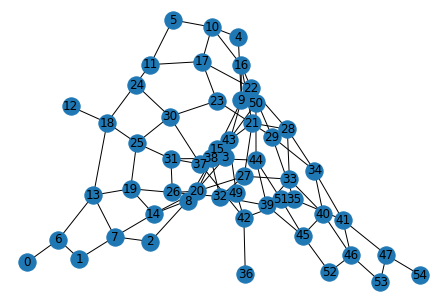

In [106]:
G = nx.Graph()
G.add_edges_from(c_map_google)
nx.draw(G, with_labels=True)
